<h2 align=center> <b>FACIAL EXPRESSION RECOGNITION USING OCCLUDED IMAGES</b></h2>








# Import Libraries


In [1]:
!wget https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py

--2020-06-10 08:38:46--  https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6935 (6.8K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   6.77K  --.-KB/s    in 0s      

2020-06-10 08:38:46 (76.7 MB/s) - ‘utils.py.1’ saved [6935/6935]



In [2]:
pip install livelossplot

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
import tensorflow.python.keras.engine
print("Tensorflow version:", tf.__version__)

--2020-06-10 08:44:57--  https://raw.githubusercontent.com/mixuala/colab_utils/master/tboard.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5203 (5.1K) [text/plain]
Saving to: ‘tboard.py’

tboard.py           100%[===================>]   5.08K  --.-KB/s    in 0s      

2020-06-10 08:44:58 (20.2 MB/s) - ‘tboard.py’ saved [5203/5203]



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

ngrok installed


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

status: tensorboard=False, ngrok=True
tensorboard url= https://5e8977aef249.ngrok.io
Tensorflow version: 1.14.0


Using TensorFlow backend.


In [4]:
pip install talos

# Extracting Files

In [8]:
from zipfile import ZipFile
file_name = '/content/FER final.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Plotting sample images


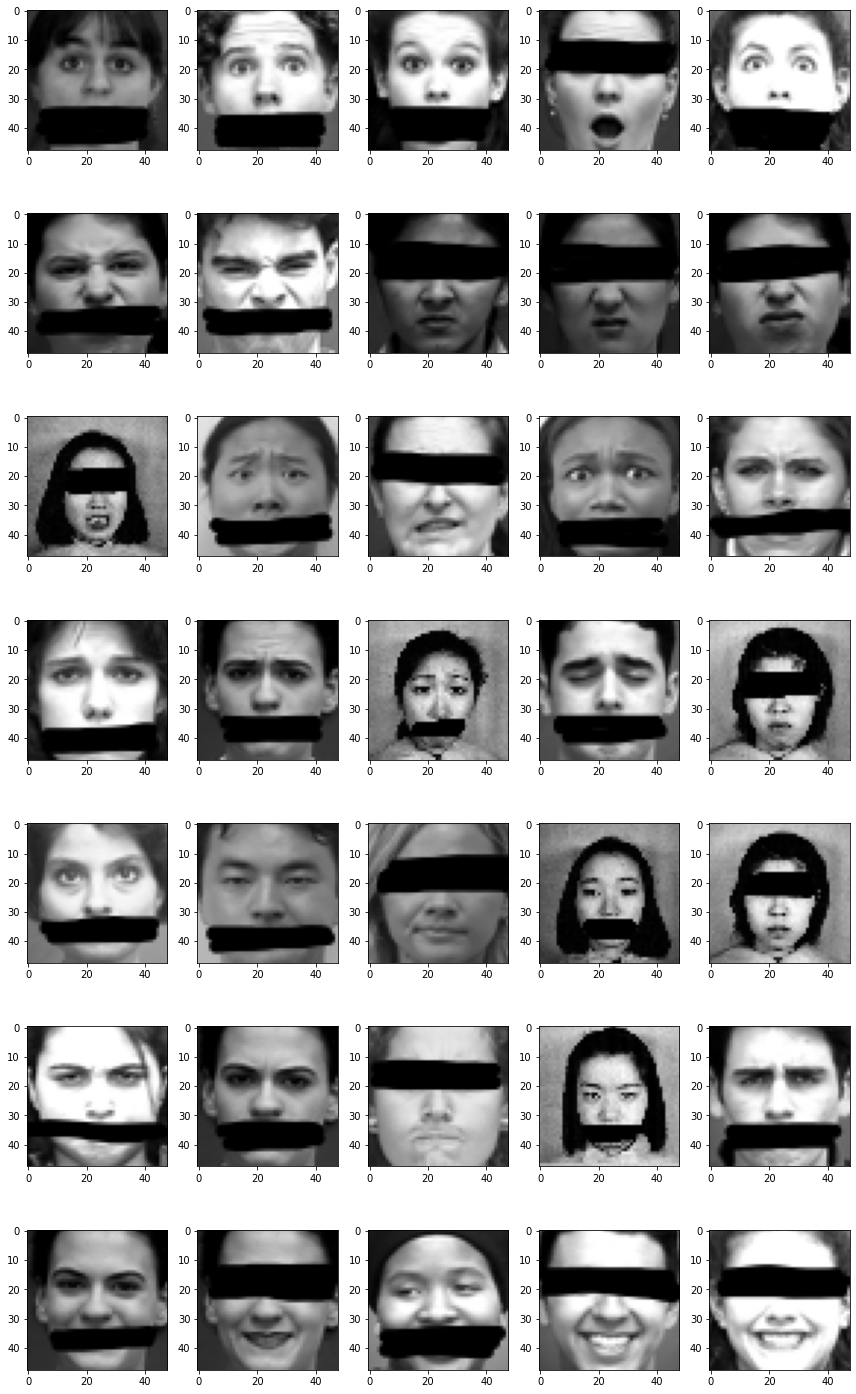

In [10]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

img_size = 48
plt.figure(0, figsize=(12,20))
ctr = 0
 
for expression in os.listdir("/content/FER/train/"):
    for i in range(1,6):
        ctr += 1
        plt.subplot(7,5,ctr)
        img = load_img("/content/FER/train/" + expression + "/" +os.listdir("/content/FER/train/" + expression)[i], target_size=(img_size, img_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [11]:
for expression in os.listdir("/content/FER/train/"):
    print(str(len(os.listdir("/content/FER/train/" + expression))) + " " + expression + " images")

190 Surprise images
133 Disgust images
66 Fear images
73 Sad images
57 Neutral images
92 Angry images
162 Happy images


# Generating Training and Validation Batches

In [12]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("/content/FER/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("/content/FER/test/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 773 images belonging to 7 classes.
Found 421 images belonging to 7 classes.


# Creating CNN Model

In [13]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy','CategoricalAccuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
____

# Training and evaluating the model

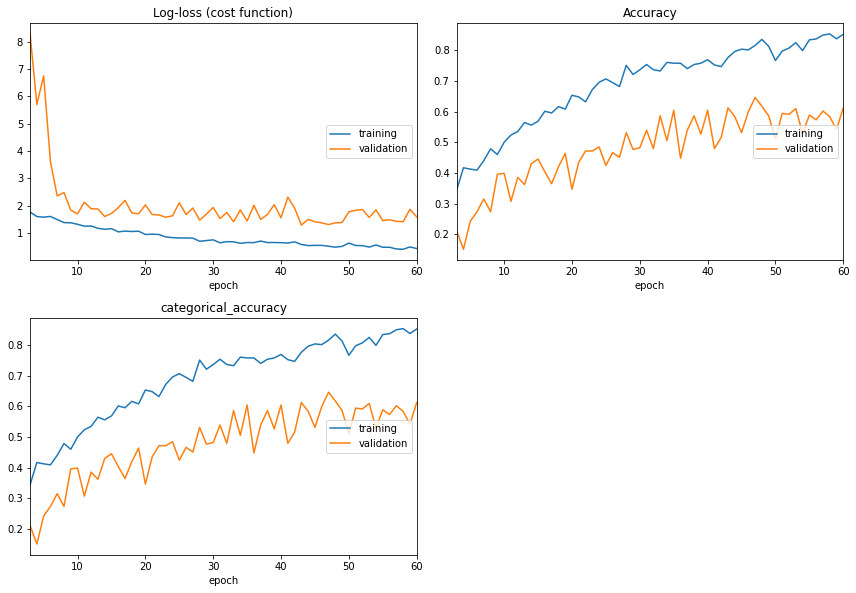

Log-loss (cost function):
training   (min:    0.404, max:    2.200, cur:    0.432)
validation (min:    1.288, max:   19.254, cur:    1.592)

Accuracy:
training   (min:    0.209, max:    0.853, cur:    0.852)
validation (min:    0.135, max:    0.646, cur:    0.612)

categorical_accuracy:
training   (min:    0.209, max:    0.853, cur:    0.852)
validation (min:    0.135, max:    0.646, cur:    0.612)

Epoch 00060: saving model to new_model_weights.h5
12/12 [==============================] - 46s 4s/step - loss: 0.4323 - acc: 0.8516 - categorical_accuracy: 0.8516 - val_loss: 1.5916 - val_acc: 0.6120 - val_categorical_accuracy: 0.6120
CPU times: user 1h 23min 14s, sys: 1min 16s, total: 1h 24min 30s
Wall time: 44min 17s


In [14]:
%%time

epochs = 60
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.001, mode='auto')
checkpoint = ModelCheckpoint("new_model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

# Importing .json file


In [0]:
import io
from keras.models import model_from_json
model_json = model.to_json()

with io.open('new_model.json','w') as json_file:
  json_file.write(model_json)